# Import Modules
# Detector & Predictor

In [7]:
import dlib
from utils.aux_functions import *
import argparse
from matplotlib import pyplot as plt
import cv2

detector = dlib.get_frontal_face_detector() # 얼굴 좌표찾기 함수 (여러명도 가능)

path_to_dlib_model = "./dlib_models/shape_predictor_68_face_landmarks.dat"
if not os.path.exists(path_to_dlib_model):
    download_dlib_model()
    
predictor = dlib.shape_predictor(path_to_dlib_model) # 얼굴 랜드마크 68개 점 찾기

# Define Function(mask_the_face_correctly)

In [8]:
def mask_the_face_correctly(face_image):
    
    ##### 얼굴 좌표 찾기 #####
    face_locations = detector(face_image, 1) # return rectangles 객체 (여러명 얼굴인식)
    face_location = face_locations[0] # 1명만 얼굴인식
    
    
    ##### 얼굴 랜드마크별 68개 좌표 찾기 #####
    shape = predictor(face_image, face_location) # 68개 점 좌표
    shape = face_utils.shape_to_np(shape)
    face_landmarks = shape_to_landmarks(shape) # 얼굴 랜드마크별 68개의 점 좌표(groupby)
    face_location = rect_to_bb(face_location) # rectangles 객체를 튜플로 변환

    
    ##### 마스크를 씌울 6개의 얼굴좌표, 얼굴각도 #####
    six_points_on_face, angle = get_six_points(face_landmarks, face_image)  
    
    
    ##### 얼굴 각도 판단 후 어떤 마스크를 쓸것인지 선정 #####
    threshold = 13 # 얼굴각도 임계수치
    mask_type = "surgical"
    if angle < -threshold:
        mask_type += "_right"
    elif angle > threshold:
        mask_type += "_left"
        
    cfg = read_cfg(config_filename="./masks/masks.cfg", mask_type=mask_type, verbose=False)
    mask_image = cv2.imread(cfg.template, cv2.IMREAD_UNCHANGED) # cv2.IMREAD_UNCHANGED : 투명도인 Alpha 채널을 포함하여 원본 그대로 읽는다
    mask_dots = np.float32([cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]) # 마스크 육각형 꼭지점 좌표
    
    
    ##### 마스크 위치를 얼굴 위치(6개 좌표)와 동기화 #####
    M, mask = cv2.findHomography(mask_dots, six_points_on_face)
    w = face_image.shape[1] # 이미지 열 크기(가로)
    h = face_image.shape[0] # 이미지 행 크기(세로)
    dst_mask = cv2.warpPerspective(mask_image, M, (w, h))
    dst_mask_points = cv2.perspectiveTransform(mask_dots.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    
    
    ##### 얼굴에 마스크 합성 #####    
    # Adjust Brightness
    mask_brightness = get_avg_brightness(mask_image)
    img_brightness = get_avg_brightness(face_image)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(mask_image)
    img_saturation = get_avg_saturation(face_image)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(face_image, face_image, mask=mask_inv) # 얼굴이미지 마스크부분 배경제거(비트연산)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask) # 마스크 이외 배경제거(비트연산)
    with_mask = cv2.add(img_bg, img_fg[:, :, 0:3])
    
    
    return with_mask 

# Mask The Face in Directory

In [9]:
import glob

img_path_list = glob.glob('../Gray Scaled Classification/with_mask/*.jpg')
print(len(img_path_list)) # 10000개

for i, img_path in enumerate(img_path_list): 
    original_image = cv2.imread(img_path)
    face_image = original_image.copy()

    try:
        with_mask = mask_the_face_correctly(face_image)

        new_img_path = '../Gray Scaled Classification/with_mask_result/with_mask_' + str(i) + '.jpg' 
        cv2.imwrite(new_img_path, with_mask)
        
        if i % 500 == 0:
            print('complete:', img_path)
            
    # 모든 예외의 에러 메시지를 출력할 때는 Exception을 사용
    except Exception as e:
        print('Error:', e, img_path) # ../Gray Scaled Classification/with_mask/with_mask_2663.jpg 오류(제거)

10000
complete: ../Gray Scaled Classification/with_mask/with_mask_0.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_500.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_1000.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_1500.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_2000.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_2500.jpg
Error:  ../Gray Scaled Classification/with_mask/with_mask_2663.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_3000.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_3500.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_4000.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_4500.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_5000.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_5500.jpg
complete: ../Gray Scaled Classification/with_mask/with_mask_6000.jpg
complete: ../Gray Scaled Classific

In [10]:
original_image = cv2.imread('../Gray Scaled Classification/with_mask/with_mask_2663.jpg')
face_image = original_image.copy()

with_mask = mask_the_face_correctly(face_image)
new_img_path = '../Gray Scaled Classification/with_mask_result/with_mask_2663.jpg'
cv2.imwrite(new_img_path, with_mask)

IndexError: 

IndexError: 

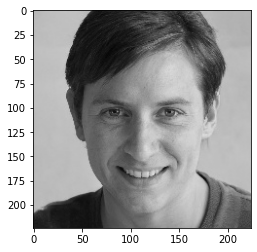

In [13]:
plt.imshow(face_image)
tt = mask_the_face_correctly(face_image).detector(face_image, 1)
print(tt)